# Topographic Maps of the Telescope Array Cosmic Ray Observatory Using STRM Data #
## Author : Greg Furlich
## Data : 2019-02-06
### Purpose : Loading STRM data, zooming in on the telescape array cosmic ray observatory, and overlaying information in a topographic and shaded relief map.
More at [Telescope Array Topography Maps using STRM Data](https://gregfurlich.com/posts/telescope-array-satellite-map.html)

# Import Python Libraries #

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio
import math

# Load STRM Data #
[STRM data](http://srtm.csi.cgiar.org/download)

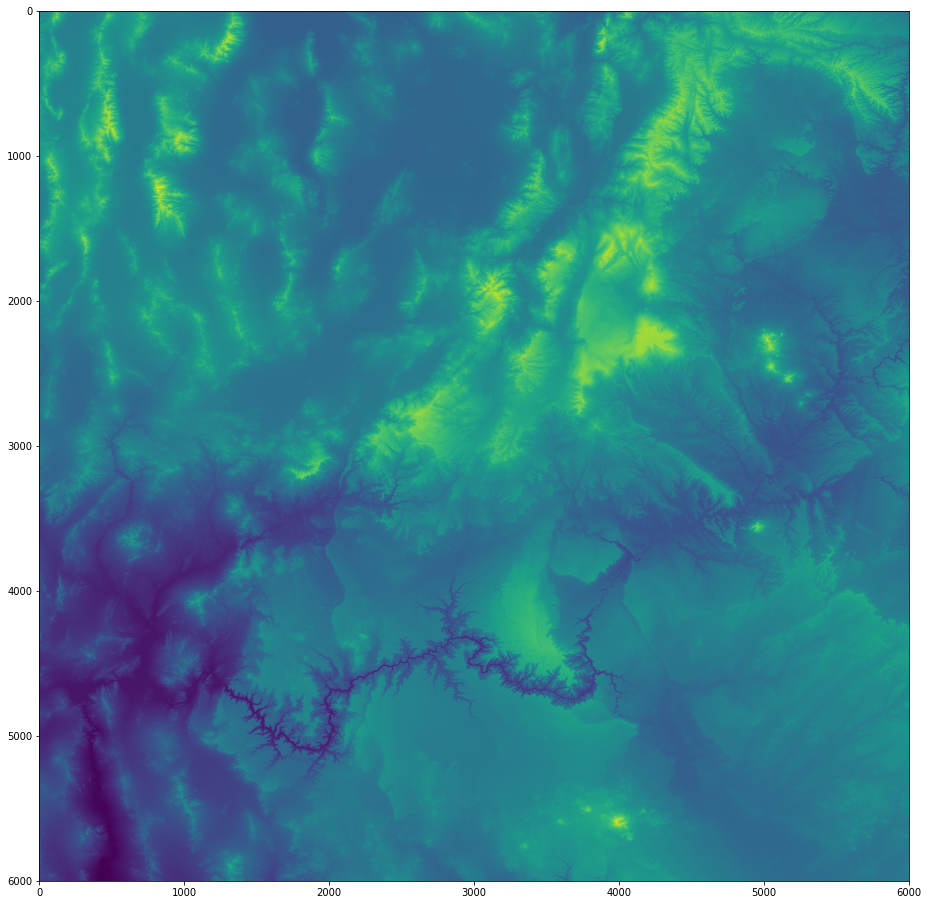

In [2]:
dir = '/GDF/TAResearch/TAmap'

topo = gdal.Open(dir+'/srtm_14_05.tif')
# print(topo)

# Read in raster array 
topo = topo.ReadAsArray().astype(np.float)
# print(topo)

# Plot whole raster #
fig = plt.figure(figsize=(16,16))
plt.imshow(topo)
plt.savefig('srtm_14_05.svg')
plt.savefig('srtm_14_05.png', dpi=300)

# Determine Pixel Size and Raster Info from TFW file #

In [3]:
## Read Values from TFX File ##
file = dir + '/srtm_14_05.tfw'

# TFW File Contents #
'''
            0.0008333333
            0.0000000000
            0.0000000000
           -0.0008333333
         -114.9999998789
           40.0000000968
'''

# Read Lines from File and Format #
f = open(file, 'r') 
t = f.readlines()
t = [ i.replace('\n','') for i in t ]
t = [ i.replace(' ','') for i in t ]
f.close()

## Get Rows and Columns of pixel length ##
nrow, ncol = topo.shape
print(nrow, ncol)

# Pixel size #
# x pixel length
dx = float(t[0])
# y pixel length
dy = float(t[3])
# Upper Left Corner Longitude #
lon_ul = float(t[4])
# Upper left Corner Latitude #
lat_ul = float(t[5])

print(dx, dy, lat_ul, lon_ul)
print( dx * ncol + lon_ul, dy * nrow + lat_ul)       

6001 6001
0.0008333333 -0.0008333333 40.0000000968 -114.9999998789
-109.9991667456 34.9991669635


# Read in STRM GEOTIFF Information #

In [4]:
## Reader in Header File For Corner Locations ##
file = dir + '/srtm_14_05.hdr'

# Read Lines from File and Format #
f = open(file, 'r') 
t = f.readlines()
t = [ i.replace('\n','') for i in t ]
t = [ i.replace(' ','') for i in t ]
f.close()

# Raster Corner Coordinates #
# Upper Left Corner Coordinates #
ul = [float(i) for i in t[-5].split('(')[1].replace(')','').split(',')]
# Lower Left Corner Coordinates #
ll = [float(i) for i in t[-4].split('(')[1].replace(')','').split(',')]
# Upper Right Corner Coordinates #
ur = [float(i) for i in t[-3].split('(')[1].replace(')','').split(',')]
# Lower Right Corner Coordinates #
lr = [float(i) for i in t[-2].split('(')[1].replace(')','').split(',')]
# Center Coordinates #
center = [float(i) for i in t[-1].split('(')[1].replace(')','').split(',')]
print(ul, ll, ur, lr, center)

d_lat = ul[1] - ll[1], ur[1] - lr[1]
d_lon = ul[0] - ur[0], ll[0] - lr[0]
print(d_lat[0]/ncol, d_lon[0]/nrow, d_lat[1]/ncol, d_lon[1]/nrow) # Matches from TFW file

[-115.0004165, 40.0004168] [-115.0004165, 34.9995834] [-109.9995832, 40.0004168] [-109.9995832, 34.9995834] [-112.4999999, 37.5000001]
0.0008333333444425937 -0.000833333327778703 0.0008333333444425937 -0.000833333327778703


# Center on Point of Interest #

In [5]:
## Crop window to Point of Interest ##
def centerPOI(max_lat, 
    min_lat, 
    max_lon, 
    min_lon, 
    raster, 
    poi_lat, 
    poi_lon, 
    pixels):
    '''
    Create a Window for the Rasters to Center on a Point of Interest (POI) within the Raster with given latitude and longitude of site.
    poi_lat = POI latitude in Degrees Decimal
    poi_lon = POI longitude in Degrees Decimal
    p = width of window in pixels. Each Pixel is 30m in width
    
    '''
    # Raster Longitude and Latitude Width #
    lon_range = max_lat - min_lat
    lat_range = max_lon - min_lon

    # Relative Position of POI #
    poi_x = 1 + (poi_lon - min_lon) / lon_range
    poi_y = 1 + (poi_lat - min_lat) / (lat_range) # Flipped y axis # 
    
    # Open Raster and Find Size #
    raster =  gdal.Open(raster)
    dx, dy = raster.RasterXSize, raster.RasterYSize
    
    # Find Position of POI in Raster #
    poi_x = poi_x * dx
    poi_y = poi_y * dy
    
    # Calculate Window for Focus on POI #
    # Window Corner #
    x_o, y_o = poi_x - .5 * pixels, poi_y - .5 * pixels
    window = rasterio.windows.Window(x_o, y_o, pixels, pixels)
    
    return window

def acenterPOI(max_lat, 
    min_lat, 
    max_lon, 
    min_lon, 
    raster, 
    poi_lat, 
    poi_lon, 
    x_pixels,
    y_pixels):
    '''
    Create a Window for the Rasters to Center on a Point of Interest (POI) within the Raster with given latitude and longitude of site.
    poi_lat = POI latitude in Degrees Decimal
    poi_lon = POI longitude in Degrees Decimal
    p = width of window in pixels. Each Pixel is 30m in width
    
    '''
    # Raster Longitude and Latitude Width #
    lon_range = max_lat - min_lat
    lat_range = max_lon - min_lon

    # Relative Position of POI #
    poi_x = 1 + (poi_lon - min_lon) / lon_range
    poi_y = 1 + (poi_lat - min_lat) / (lat_range) # Flipped y axis # 
    
    # Open Raster and Find Size #
    raster =  gdal.Open(raster)
    dx, dy = raster.RasterXSize, raster.RasterYSize
    
    # Find Position of POI in Raster #
    poi_x = poi_x * dx
    poi_y = poi_y * dy
    
    # Calculate Window for Focus on POI #
    # Window Corner #
    x_o, y_o = poi_x - .5 * x_pixels, poi_y - .5 * y_pixels
    window = rasterio.windows.Window(x_o, y_o, x_pixels, y_pixels)
    
    return window

# Telescope Array Site Info #

In [6]:
# See http://telescopearray.org/tawiki/index.php/CLF/FD_site_locations#Notes
site_name = ['Central Laser Facility','Black Rock Mesa','Long Ridge', 'Middle Drum']
site = ['CLF','BR','LR','MD']
site_color = ['blue', 'red', 'green', 'purple']
lat_dd = [39.29693,39.18830,39.20792,39.47282]
long_dd = [-112.90875,-112.71170,-113.12147,-112.99366]
alt_m = [1382,1404,1554,1600]
clf_x_km = [0,17.02811,-18.37754,-7.30807]
clf_y_km = [0,-12.0442,-9.86272,19.53612]
clf_z_km = [0,-.012095,.137922,.183828]
# FOV in CW from North #
fov_azm_i = [0, 242, 18, 102]
fov_azm_f = [0, 350, 125, 218]
lat_deg = [39, 39, 39, 39]
long_deg = [112, 112, 113, 112]
lat_min = [17, 11, 12, 28]
long_min = [54, 42, 7, 59]
lat_sec = [48.44864, 18.09744, 28.32926, 22.04278]
long_sec = [31.81968, 45.44298, 14.24482, 39.15719]
lat = [ deg +  min/60 + sec/3600 for (deg, min, sec) in zip(lat_deg, lat_min, lat_sec)]
long = [ -1 * (deg +  min/60 + sec/3600) for (deg, min, sec) in zip(long_deg, long_min, long_sec)]

TA = {'Site Name': site_name,
      'Site': site,
      'Color': site_color,
      'Latitude': lat,
      'Longitude': long,
      'Altitude': alt_m,
      'X': clf_x_km,
      'Y': clf_y_km,
      'Z': clf_z_km,
      'FOVi': fov_azm_i,
      'FOVf': fov_azm_f,
      'Latitude DD': lat_dd,
      'Longitude DD': long_dd,}

## Convert Dictionary to Pandas DF ##
ta_df = pd.DataFrame(TA)
display(ta_df)

,Site Name,Site,Color,Latitude,Longitude,Altitude,X,Y,Z,FOVi,FOVf,Latitude DD,Longitude DD
0,Central Laser Facility,CLF,blue,39.296791,-112.908839,1382,0.00000,0.00000,0.000000,0,0,39.29693,-112.90875
1,Black Rock Mesa,BR,red,39.188360,-112.712623,1404,17.02811,-12.04420,-0.012095,242,350,39.18830,-112.71170
2,Long Ridge,LR,green,39.207869,-113.120624,1554,-18.37754,-9.86272,0.137922,18,125,39.20792,-113.12147
3,Middle Drum,MD,purple,39.472790,-112.994210,1600,-7.30807,19.53612,0.183828,102,218,39.47282,-112.99366


# Haversine and Bearing Functions #

In [7]:
def haversine(longitude_1, latitude_1, longitude_2, latitude_2):
    """
    Calculate the great circle distance between two points p1 and p2
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians #
    longitude_1, latitude_1, longitude_2, latitude_2 = map(math.radians, [longitude_1, latitude_1, longitude_2, latitude_2])

    # haversine formula #
    dlongitude = longitude_2 - longitude_1 
    dlatitude = latitude_2 - latitude_1 
    a = math.sin(dlatitude/2)**2 + math.cos(latitude_1) * math.cos(latitude_2) * math.sin(dlongitude/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    
    # Earth Radius in m from wikipedia #
    radius = [6378100, 6356800, 6378137, 6356752.3141, 6399593.6259, 
              6371008.7714, 6371007.1810, 6371000.7900, 6378137.0, 
              6356752.3142, 6399593.6258, 6371008.7714, 6371007.1809, 
              6371000.7900, 6378137.0, 6356752.314140, 6335439, 
              6384400, 6352800, 6371230]
    description = [
        'nominal \"zero tide\" equatorial',
        'nominal \"zero tide\" polar ',
        'equatorial radius',
        'semiminor axis (b)',
        'polar radius of curvature (c)',
        'mean radius (R1)',
        'radius of sphere of same surface (R2)',
        'radius of sphere of same volume (R3)',
        'WGS-84 ellipsoid, semi-major axis (a)',
        'WGS-84 ellipsoid, semi-minor axis (b)',
        'WGS-84 ellipsoid, polar radius of curvature (c)',
        'WGS-84 ellipsoid, Mean radius of semi-axes (R1)',
        'WGS-84 ellipsoid, Radius of Sphere of Equal Area (R2)',
        'WGS-84 ellipsoid, Radius of Sphere of Equal Volume (R3)',
        'GRS 80 semi-major axis (a)',
        'GRS 80 semi-minor axis (b)',
        'meridional radius of curvature at the equator',
        'Maximum (the summit of Chimborazo)',
        'Minimum (the floor of the Arctic Ocean)',
        'Average distance from center to surface'
    ]
    
    R_Earth = {'r': radius, 'description': description}
    R_Earth = pd.DataFrame(R_Earth)
    
    # Radius of the Earth in km #
    r = (R_Earth['r'][3] + ta_df['Altitude'][0])/ 1000
    #r = R_Earth['r'][3]/ 1000
    
    # Bearing Angle CW from North
    bearing = math.atan2(math.sin(longitude_2-longitude_1)*math.cos(latitude_2), math.cos(latitude_1)*math.sin(latitude_2)-math.sin(latitude_1)*math.cos(latitude_2)*math.cos(longitude_2-longitude_1))
 
    # Great Circle Distance #
    d = c * r
    
    # Convert Bearing Angle to degrees #
    # bearing = bearing * 180 / pi
        
    return d, bearing

def CLF_coord(longitude, latitude):
    '''
    Calculates the x and y components of distance between a a point with decimal degree longitude, latitude.
    CLF Coordinates :
    +x : East [m]
    +y : North [m]
    '''
    clf_longitude, clf_latitude = ta_df['Longitude'][0], ta_df['Latitude'][0]
    
    d, bearing = haversine(clf_longitude, clf_latitude, longitude, latitude)
        
    # Find the x and y component of the Distance #
    x = d * math.sin(bearing)
    y = d * math.cos(bearing)
    
    return x, y

def degdiff2meters(longitude_1, latitude_1, longitude_2, latitude_2, pixels):
        
    d, bearing = haversine(longitude_1, latitude_1, longitude_2, latitude_2)
        
    # Find the x and y component of the Distance #
    dx = d * math.sin(bearing) / pixels
    dy = d * math.cos(bearing) / pixels
    
    return dx, dy

# Set Window to Telescope Array Cosmic Ray Observatory #

Window(col_off=2009.8933265403252, row_off=344.3504989613915, width=1000.0, height=1000.0)


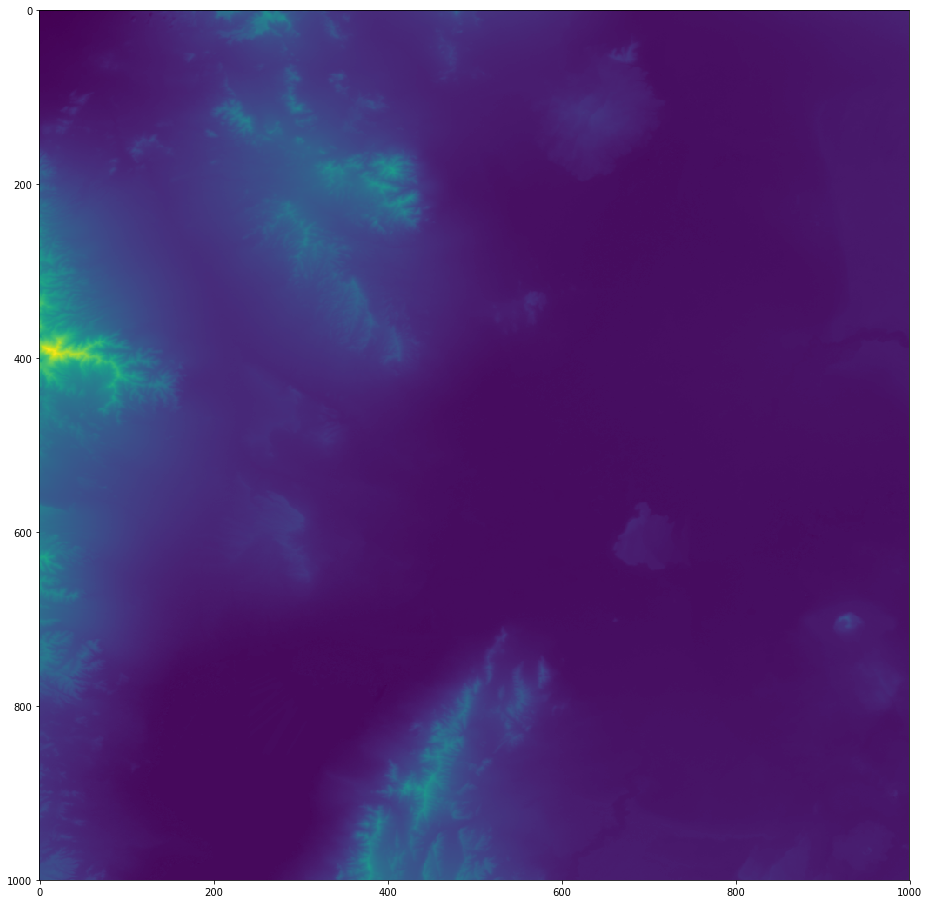

In [8]:
# Corners #
max_lat = ul[1]
min_lat = ll[1] 
max_lon = ul[0] 
min_lon = ur[0]

window = centerPOI(poi_lat = ta_df['Latitude'][0], 
              poi_lon =ta_df['Longitude'][0], 
              max_lat = max_lat, 
              min_lat = min_lat, 
              max_lon = max_lon, 
              min_lon = min_lon, 
              raster = dir + '/srtm_14_05.tif', 
              pixels = 60 * 1000 / 60 )

# x_uc, y_uc = 2200, 500
# pixels = 1000
# window = window = rasterio.windows.Window(x_uc,y_uc,pixels,pixels)
print(window)

cropped_topo = rasterio.open(dir + '/srtm_14_05.tif').read(1, window=window)
cropped_topo = cropped_topo.astype(np.int)

fig = plt.figure(figsize=(16,16))
plt.imshow(cropped_topo)
plt.savefig('Delta_topo.png', dpi=300)

# Edit Colormap and add colorbar #

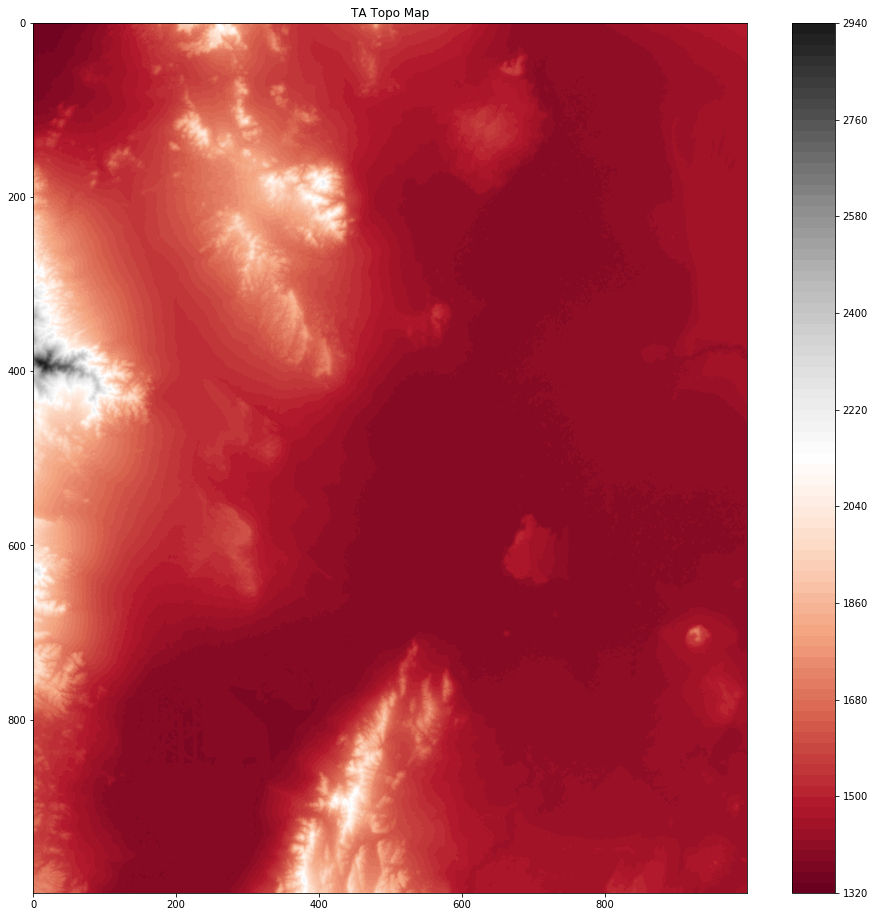

In [9]:
fig = plt.figure(figsize=(16,16))
cp = plt.contourf(cropped_topo, 100, cmap='RdGy')
# plt.clabel(cp, inline=True, 
#           fontsize=10)

plt.gca().invert_yaxis()

plt.title('TA Topo Map')

# Color Bar #
plt.colorbar(cp)

plt.show()

# Field of View Arcs for Overlays #

In [10]:
## Create Field of View Arcs for site ##
def FOV_arc(r,ang_i,ang_f,xo,yo):
    d_ang = 100
    ang = np.linspace(ang_i,ang_f,d_ang)
    ring_x = r * np.sin(ang * np.pi / 180) + xo
    ring_y = r * np.cos(ang * np.pi / 180) + yo
    ring_x = np.concatenate(([xo],ring_x,[xo]))
    ring_y = np.concatenate(([yo],ring_y,[yo]))
    
    return ring_x, ring_y

# Pixel size #

In [11]:
max_lat = ul[1]
min_lat = ll[1] 
max_lon = ul[0] 
min_lon = ur[0]

px, py =  degdiff2meters(max_lon, max_lat, min_lon, min_lat, 6001)
px, py = px * 1000 - 4, -1 * py * 1000 + 2
print(px, py)

71.81220846712516 92.42112689799902


# Topographic image of Each FD site and CLF #

1 CLF 39.29679128888889 -112.90883880000001
2 BR 39.18836039999999 -112.71262305
3 LR 39.20786923888889 -113.1206235611111
4 MD 39.472789661111115 -112.99421033055556


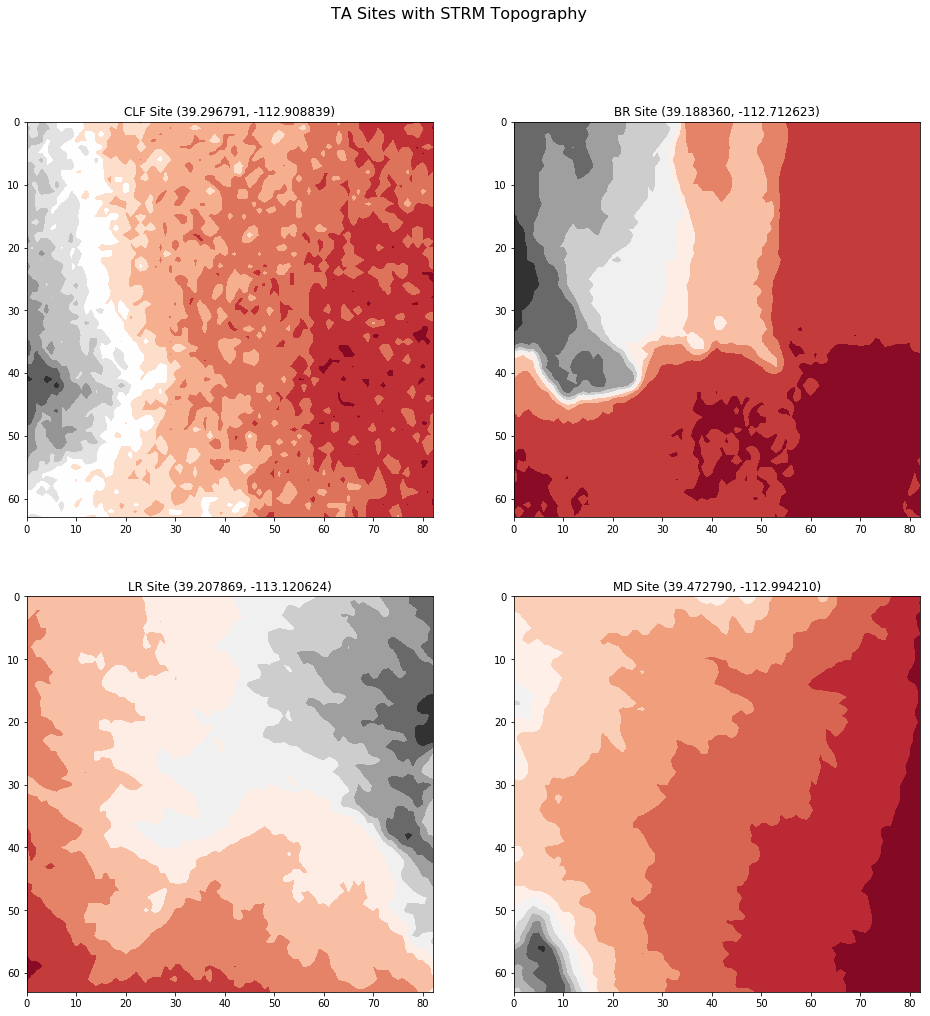

In [12]:
## Create An Image of Each Site Zoomed in ##
fig = plt.figure(figsize=(16,16))
for (i, site, poi_lat, poi_lon) in zip(range(1,len(ta_df)+1),ta_df['Site'].values,ta_df['Latitude'].values,ta_df['Longitude'].values):
    plt.subplot(2,2,i)
    print(i, site, poi_lat, poi_lon)
    
    ## Finding Offset from recorded CLF lat and Long values to Center CLF ##
#     lat_offset, lon_offset = -.015, -.017
    
    # Create Window #
    window = acenterPOI(poi_lat = poi_lat, 
              poi_lon = poi_lon, 
              max_lat = max_lat, 
              min_lat = min_lat, 
              max_lon = max_lon, 
              min_lon = min_lon, 
              raster = dir + '/srtm_14_05.tif', 
              x_pixels = 6 * 1000 / px,
              y_pixels = 6 * 1000 / py)

    # Load Topo #
    site_topo = rasterio.open(dir + '/srtm_14_05.tif').read(1, window=window)

#     print(site_topo)
    
    # Plot Site #
    plt.contourf(site_topo, 10, cmap='RdGy')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.title('{0} Site ({1:.6f}, {2:.6f})'.format(site, poi_lat, poi_lon))

# cbar = fig.colorbar(cp, shrink=0.5)
# cbar.set_ylabel('Altitude [m]')

fig.suptitle('TA Sites with STRM Topography', fontsize=16)
plt.savefig('ta_topo_sites.svg')
plt.savefig('ta_topo_sites.png', dpi=300)

# Import Surface Detector (SD) Positions #

In [13]:
## Import SD Positions ##
import re

# import .gpx file #
file_gps = '/GDF/TAResearch/TAmap//TASD.gpx' 

sd_lat = []
sd_lon = []
sd_id = []
sd_cmt = []
sd_alt = []
fgps = open(file_gps,'r')
for line in fgps.readlines():
#     print(line)
    # Find Lat and Lon #
    if re.findall('<wpt lat="([-0-9\.]+)" lon="([-0-9\.]+)">', line):
        latlon = re.findall('<wpt lat="([-0-9\.]+)" lon="([-0-9\.]+)">', line)
        sd_lat.append(float(latlon[0][0]))
        sd_lon.append(float(latlon[0][1])) 
    # Find ID #
    if re.findall('<name>([0-9]+)</name>', line):
        id = re.findall('<name>([0-9]+)</name>', line)
        sd_id.append(int(id[0]))
    # Find Comm Tower ##
    if re.findall('<cmt>(\D+)</cmt>', line):
        cmt = re.findall('<cmt>(\D+)</cmt>', line)
        sd_cmt.append(cmt[0])
    # Find Altitude #
    if re.findall('ele>([0-9\.]+)</ele>', line):
        alt = re.findall('<ele>([0-9\.]+)</ele>', line)
        sd_alt.append(float(alt[0]))

sd_x, sd_y = [], []
for (lat,lon) in zip(sd_lat,sd_lon):
    x, y = CLF_coord(lon, lat)
    sd_x.append(x)
    sd_y.append(y)
    
# sd_x, sd_y = [ x, y = CLF_coord(lon, lat) for (lat,lon) in zip(sd_lat,sd_lon)] 
sd_df = {'Latitude':sd_lat,'Longitude':sd_lon,'ID':sd_id,'altitude':sd_alt,'Communication Tower':sd_cmt,'X':sd_x,'Y':sd_y}

sd_df = pd.DataFrame(sd_df)
sd_df.head()

,Latitude,Longitude,ID,altitude,Communication Tower,X,Y
0,39.18403,-113.06582,106,1514.02,LR,-13.502807,-12.501457
1,39.19500,-113.06521,107,1497.08,LR,-13.448237,-11.284204
2,39.20562,-113.06496,108,1487.89,LR,-13.424705,-10.105736
3,39.21656,-113.06511,109,1490.37,LR,-13.435509,-8.891699
4,39.22761,-113.06534,110,1490.11,LR,-13.453164,-7.665443


# Telescope Array Cosmic Ray Observatory Topographic Map with Information Overlayed #

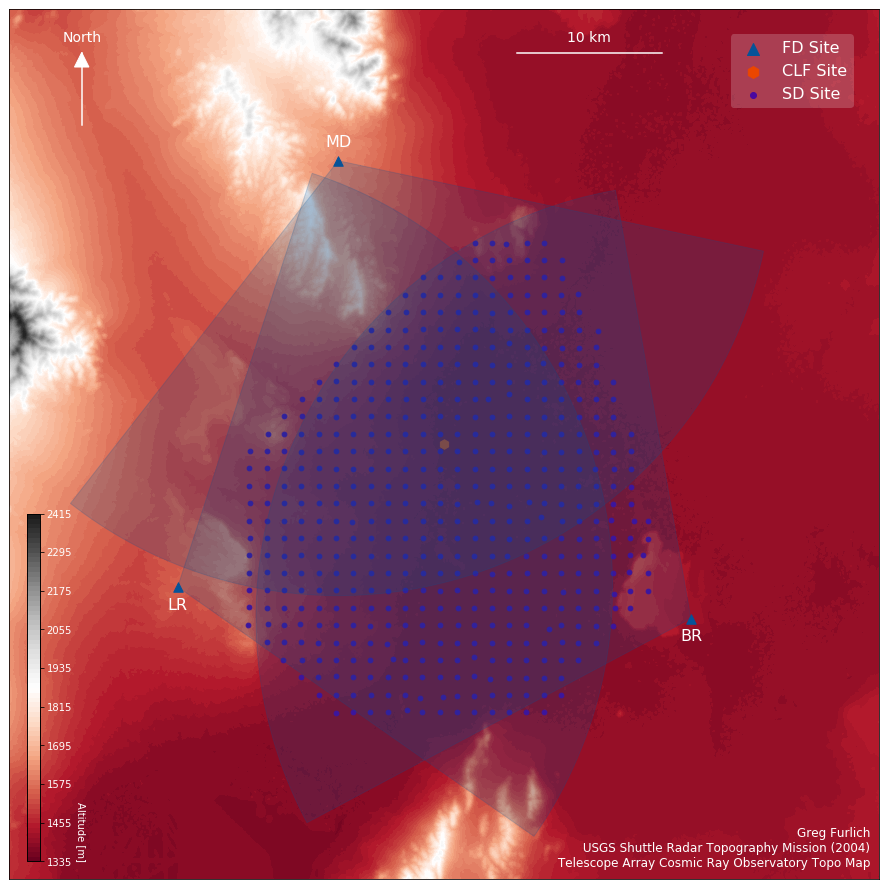

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Composite Array Plot ##
lat_offset, lon_offset = 0, -.005
# lat_offset, lon_offset = 0, 0
poi_lat = ta_df['Latitude'][0] + lat_offset 
poi_lon = ta_df['Longitude'][0] + lon_offset
    
window = acenterPOI(poi_lat = poi_lat, 
              poi_lon = poi_lon, 
              max_lat = max_lat, 
              min_lat = min_lat, 
              max_lon = max_lon, 
              min_lon = min_lon, 
              raster = dir + '/srtm_14_05.tif', 
              x_pixels = 60 * 1000 / px,
              y_pixels = 60 * 1000 / py)

cropped_topo = rasterio.open(dir + '/srtm_14_05.tif').read(1, window=window)

# FOV Rings #
FOV_x, FOV_y = [], []
FOV_c = []   
for (ang_i, ang_f, xo, yo, color) in zip(ta_df['FOVi'].values,ta_df['FOVf'].values,ta_df['X'].values,ta_df['Y'].values,ta_df['Color'].values):
    r = 30
    x, y = FOV_arc(r, ang_i, ang_f, xo, yo)
    FOV_x.append(x)
    FOV_y.append(y)
    FOV_c.append(color)
    
fig = plt.figure(figsize=(16,16))

# Topo Background #

# cmap = 'gist_earth'
cmap = 'RdGy'
# cmap = 'Greens_r'
# cmap = 'Reds_r'
# cmap = 'cubehelix'
# cmap = 'viridis'

ax=fig.add_subplot(111)
cp = ax.contourf(cropped_topo, 100, cmap=cmap)
ax.invert_yaxis()
ax.tick_params(size=0)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_aspect(py/px)

axins = inset_axes(ax,
                   width="1.5%",  # width = 10% of parent_bbox width
                   height="40%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(.02, 0.02, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

fig.colorbar(cp, cax=axins)

# FD Site Back Grounds #
clr_clf = '#EB4600'
clr_fd = '#065398'
clr_sd = '#4908A0'

ax2 = fig.add_subplot(111, frame_on=False)

# FD Sites #
# for (lat,lon,color,label) in zip(ta_df['Latitude DD'],ta_df['Longitude DD'],ta_df['Color'],ta_df['Site']):
#     x, y = CLF_coord(lon,lat)
for (x,y,label) in zip(ta_df['X'],ta_df['Y'],ta_df['Site']):
    if label == 'CLF' : ax2.scatter(x,y,marker='h', s=90, color=clr_clf)
    else : ax2.scatter(x,y,marker='^', s=90, color=clr_fd)
# SD Sites #
for (x,y) in zip(sd_df['X'],sd_df['Y']):
    ax2.scatter(x,y,marker='.', s=90, color=clr_sd)
# Label Sites #
for (x,y,text) in zip(ta_df['X'],ta_df['Y'],ta_df['Site']):
    #print (x,y,color,label)
    if text != 'CLF':
        if text == 'MD':
            ax2.text(x,y + 1.25,text, verticalalignment='center', horizontalalignment='center', fontsize=16, color='white')
        else :
            ax2.text(x,y - 1.25,text, verticalalignment='center', horizontalalignment='center', fontsize=16, color='white')
ax2.set_xlim([-30,30])
ax2.set_ylim([-30,30])
ax2.tick_params(size=0)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
# Plot FOV #
for (x,y,c) in zip(FOV_x, FOV_y, FOV_c):
    if x[0] != 0 :
        alpha = .2
        ax2.fill(x,y,color=clr_fd,alpha=alpha)
        
# Stuff for Legend #
ax2.scatter(40,40,marker='^',color=clr_fd, label='FD Site')
ax2.scatter(40,40,marker='h',color=clr_clf, label='CLF Site')
ax2.scatter(40,40,marker='.',color=clr_sd, label='SD Site')

# Scale #
ax2.plot([5,15],[27,27],color='white')
ax2.text(10, 28, '10 km', verticalalignment='center', horizontalalignment='center', color='white', fontsize=14)

# North Compass #
ax2.plot([-25,-25],[22,27],color='white')
ax2.text(-25, 28, 'North', verticalalignment='center', horizontalalignment='center', color='white', fontsize=14)
ax2.fill([-25,-25.5,-24.5],[27,26,26],color='white')


## Attribution ##
ax.text(0.99, 0.01, 'Greg Furlich\n USGS Shuttle Radar Topography Mission (2004)\n Telescope Array Cosmic Ray Observatory Topo Map',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='white', fontsize=12)

# Plot Info #
# plt.title('Telescope Array Cosmic Ray Observatory Topo Map')
# plt.xlabel('East [km]')
# plt.ylabel('North [km]')

leg =plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), prop={'size':16}, markerscale=2, framealpha = .2)
frame = leg.get_frame()
frame.set_color('white')
frame.set_linewidth(0)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
ax2.set_aspect('equal')
# plt.tight_layout()

# Altitude Color Bar ##
cbar = fig.colorbar(cp, cax=axins)
cbar.ax.set_ylabel('Altitude [m]', y=0, ha='right', rotation=-90, va='bottom', color='white')
t = cbar.ax.get_yticklabels();
labels = [item.get_text() for item in t]
cbar.ax.set_yticklabels(labels,color = 'white')

plt.savefig('ta_topo.svg', bbox_inches='tight', pad_inches=-.1)
plt.savefig('ta_topo.png', bbox_inches='tight', pad_inches=-.1, dpi=400)

# Shaded Relief Map #

In [15]:
# Apply a Gaussian Filter to smooth topography #

# from scipy.ndimage.filters import gaussian_filter

# x, y = np.gradient(cropped_topo)
 
# slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
 
# # -x here because of pixel orders in the SRTM tile
# aspect = np.arctan2(-x, y)
 
# altitude = np.pi / 4.
# azimuth = np.pi / 2.
 
# shaded = np.sin(altitude) * np.sin(slope)\
#     + np.cos(altitude) * np.cos(slope)\
#     * np.cos((azimuth - np.pi/2.) - aspect)
# shaded = 255*(shaded + 1)/2
# sigma = 0.7 # this depends on how noisy your data is, play with it!
# shaded = gaussian_filter(shaded, sigma)

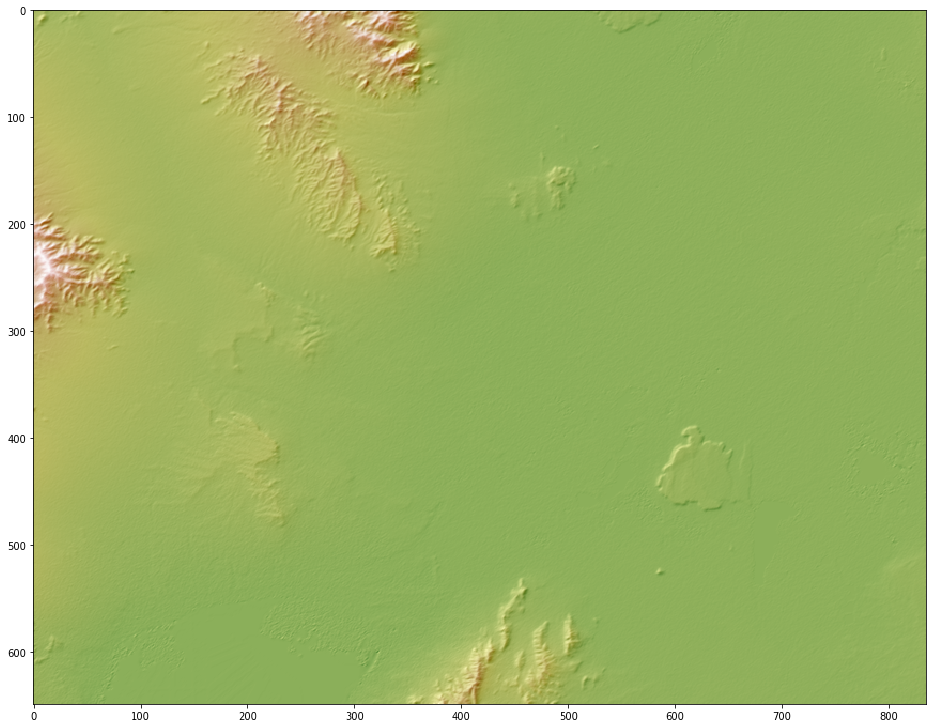

In [16]:
from matplotlib.colors import LightSource

# light source from the northwest
ls = LightSource(azdeg=315, altdeg=45)

# Shade Plot #
rgb = ls.shade(cropped_topo, cmap=plt.cm.gist_earth, vert_exag=.005, blend_mode='overlay', vmin=0)

fig = plt.figure(figsize=(16,16))
plt.imshow(rgb)
plt.savefig('delta_relief_map.svg', bbox_inches='tight', pad_inches=-.1)
plt.savefig('delta_relief_map.png', bbox_inches='tight', pad_inches=-.1, dpi=400)

# Telescope Array Cosmic Ray Observatory Shaded Relief Map with Information Overlayed #

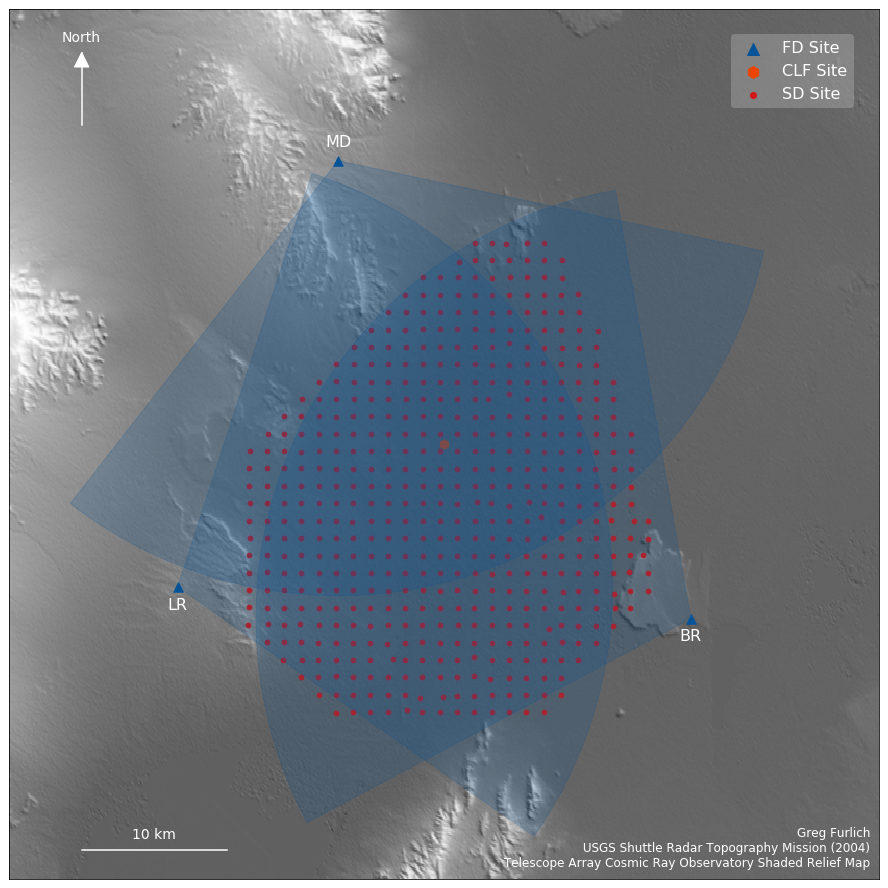

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Composite Array Plot ##
lat_offset, lon_offset = 0, -.005
poi_lat = ta_df['Latitude'][0] + lat_offset 
poi_lon = ta_df['Longitude'][0] + lon_offset
    
window = acenterPOI(poi_lat = poi_lat, 
              poi_lon = poi_lon, 
              max_lat = max_lat, 
              min_lat = min_lat, 
              max_lon = max_lon, 
              min_lon = min_lon, 
              raster = dir + '/srtm_14_05.tif', 
              x_pixels = 60 * 1000 / px,
              y_pixels = 60 * 1000 / py)

cropped_topo = rasterio.open(dir + '/srtm_14_05.tif').read(1, window=window)

# FOV Rings #
FOV_x, FOV_y = [], []
FOV_c = []   
for (ang_i, ang_f, xo, yo, color) in zip(ta_df['FOVi'].values,ta_df['FOVf'].values,ta_df['X'].values,ta_df['Y'].values,ta_df['Color'].values):
    r = 30
    x, y = FOV_arc(r, ang_i, ang_f, xo, yo)
    FOV_x.append(x)
    FOV_y.append(y)
    FOV_c.append(color)
    
fig = plt.figure(figsize=(16,16))


## Relief Map ##
ax=fig.add_subplot(111)

ls = LightSource(azdeg=45, altdeg=45)
relief_topo = ls.shade(cropped_topo, cmap=plt.cm.Greys_r, vert_exag=.005, blend_mode='overlay', vmin=1000)

ax.imshow(relief_topo)
ax.tick_params(size=0)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_aspect(py/px)

# FD Site Back Grounds #
clr_clf = '#EB4600'
clr_fd = '#065398'
clr_sd = '#d31717'

ax2 = fig.add_subplot(111, frame_on=False)

# FD Sites #
# for (lat,lon,color,label) in zip(ta_df['Latitude DD'],ta_df['Longitude DD'],ta_df['Color'],ta_df['Site']):
#     x, y = CLF_coord(lon,lat)
for (x,y,label) in zip(ta_df['X'],ta_df['Y'],ta_df['Site']):
    if label == 'CLF' : ax2.scatter(x,y,marker='h', s=90, color=clr_clf)
    else : ax2.scatter(x,y,marker='^', s=90, color=clr_fd)
# SD Sites #
for (x,y) in zip(sd_df['X'],sd_df['Y']):
    ax2.scatter(x,y,marker='.', s=90, color=clr_sd)
# Label Sites #
for (x,y,text) in zip(ta_df['X'],ta_df['Y'],ta_df['Site']):
    #print (x,y,color,label)
    if text != 'CLF':
        if text == 'MD':
            ax2.text(x,y + 1.25,text, verticalalignment='center', horizontalalignment='center', fontsize=16, color='white')
        else :
            ax2.text(x,y - 1.25,text, verticalalignment='center', horizontalalignment='center', fontsize=16, color='white')
ax2.set_xlim([-30,30])
ax2.set_ylim([-30,30])
ax2.tick_params(size=0)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
# Plot FOV #
for (x,y,c) in zip(FOV_x, FOV_y, FOV_c):
    if x[0] != 0 :
        alpha = .2
        ax2.fill(x,y,color=clr_fd,alpha=alpha)
        
# Stuff for Legend #
ax2.scatter(40,40,marker='^',color=clr_fd, label='FD Site')
ax2.scatter(40,40,marker='h',color=clr_clf, label='CLF Site')
ax2.scatter(40,40,marker='.',color=clr_sd, label='SD Site')

# Scale #
ax2.plot([-25,-15],[-28,-28],color='white')
ax2.text(-20, -27, '10 km', verticalalignment='center', horizontalalignment='center', color='white', fontsize=14)

# North Compass #
ax2.plot([-25,-25],[22,27],color='white')
ax2.text(-25, 28, 'North', verticalalignment='center', horizontalalignment='center', color='white', fontsize=14)
ax2.fill([-25,-25.5,-24.5],[27,26,26],color='white')


## Attribution ##
ax.text(0.99, 0.01, 'Greg Furlich\n USGS Shuttle Radar Topography Mission (2004)\n Telescope Array Cosmic Ray Observatory Shaded Relief Map',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='white', fontsize=12)

leg =plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), prop={'size':16}, markerscale=2, framealpha = .2)
frame = leg.get_frame()
frame.set_color('white')
frame.set_linewidth(0)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
ax2.set_aspect('equal')

plt.savefig('ta_relief.svg', bbox_inches='tight', pad_inches=-.1)
# plt.savefig('ta_topo.png', bbox_inches='tight', pad_inches=-.1, dpi=400)

# Shaded Relief Image of Each FD site and CLF #

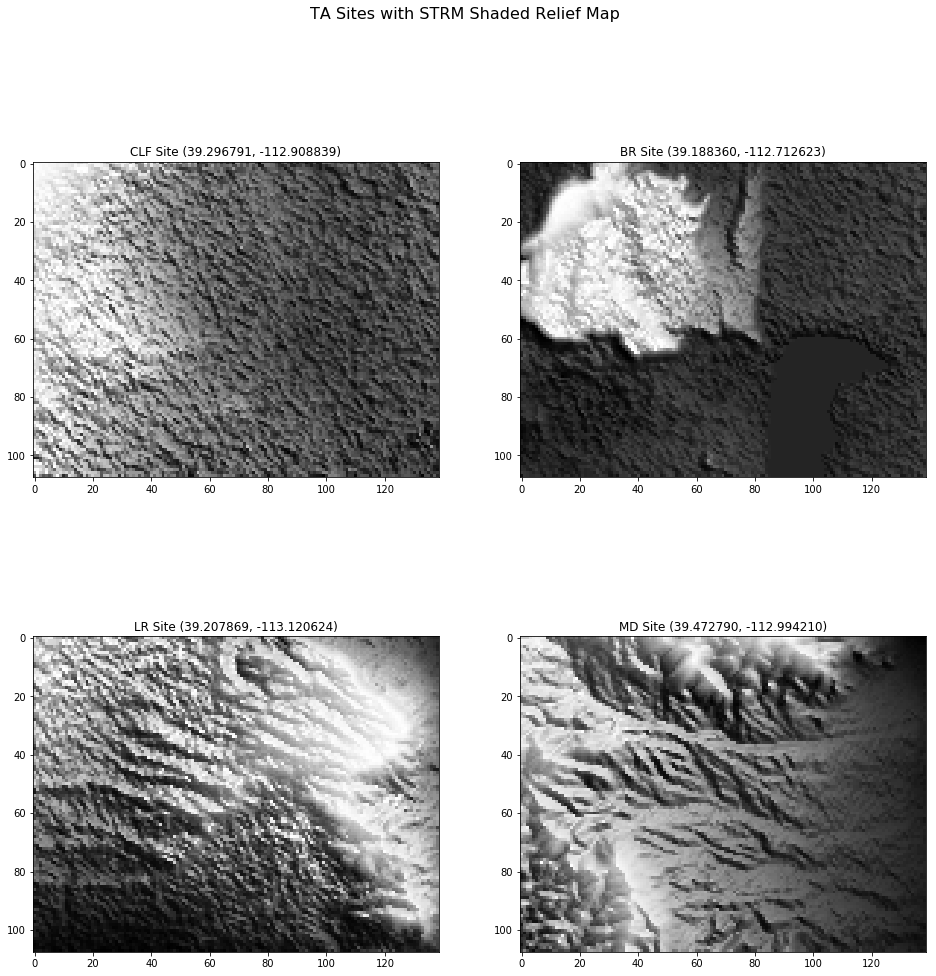

In [18]:
## Create An Image of Each Site Zoomed in ##
fig = plt.figure(figsize=(16,16))
for (i, site, poi_lat, poi_lon) in zip(range(1,len(ta_df)+1),ta_df['Site'].values,ta_df['Latitude'].values,ta_df['Longitude'].values):
    plt.subplot(2,2,i)
#     print(i, site, poi_lat, poi_lon)
    
    ## Finding Offset from recorded CLF lat and Long values to Center CLF ##
#     lat_offset, lon_offset = -.015, -.017
    
    # Create Window #
    window = acenterPOI(poi_lat = poi_lat, 
              poi_lon = poi_lon, 
              max_lat = max_lat, 
              min_lat = min_lat, 
              max_lon = max_lon, 
              min_lon = min_lon, 
              raster = dir + '/srtm_14_05.tif', 
              x_pixels = 10 * 1000 / px,
              y_pixels = 10 * 1000 / py)

    # Load Topo #
    site_topo = rasterio.open(dir + '/srtm_14_05.tif').read(1, window=window)

#     print(site_topo)
    
    # Plot Site #
#     ls = LightSource(azdeg=315, altdeg=45)
    site_relief = ls.shade(site_topo, cmap=plt.cm.Greys_r, vert_exag=1, blend_mode='overlay')

    plt.imshow(site_relief)
#     plt.contourf(site_topo, 10, cmap='RdGy')
#     ax = plt.gca()
#     ax.invert_yaxis()
    plt.title('{0} Site ({1:.6f}, {2:.6f})'.format(site, poi_lat, poi_lon))

fig.suptitle('TA Sites with STRM Shaded Relief Map', fontsize=16)
plt.savefig('ta_relief_sites.svg')
plt.savefig('ta_relief_sites.png', dpi=300)